In [2]:
###### test connection ######

import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"

In [3]:
###### check environments ######

import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
ocid1.datascienceproject.oc1.eu-zurich-1.amaaaaaa2jwq32iapkcl4klg3qulxmpxlgnyxwhf276mb6ukgtdhms5oc3ua
ocid1.saml2idp.oc1..aaaaaaaao4zb7iwgmzbhs3hcvl7qrob453qzrqzs3o2hhl23oczezxmtyz7q/ethlambda@gmail.com
ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
eu-zurich-1


In [21]:
%%bash
###### install libs ######
#pip install matplotlib
#pip install pandas
#pip install seaborn
#pip list
#pip install scikit-learn

In [1]:
###### import libs ######

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [2]:
###### check ads env ######

ads.environment.ads_inspect.check_ads_env()

Library         Version    Required
--------------  ---------  ----------
arrow           0.14.7     0.10.0
configparser    4.0.2      3.5.0
ipykernel       5.4.0      5.1.3
pyod            0.8.1      0.7.1
pyOpenSSL       18.0.0     19.0
pytest          4.0.1      5.3.5
pytest-asyncio  0.9.0      0.10.0
six             1.14.0     1.13


In [3]:
####### load data #######

name = 'd_pis'
id_col = "Id"
target_col = "Choice"

train_name = './d_pis/train_{}.csv'.format(name)
test_name = './d_pis/test_{}.csv'.format(name)

df = pd.read_csv(train_name)
test_df = pd.read_csv(test_name)

print(df.head())
df.shape

test_df.head()

   Choice  A_follower_count  A_following_count  A_listed_count  \
0       1            143101             128686            8742   
1       1              6010               3828             375   
2       0           6375552                813           13024   
3       0               219                148               8   
4       0           3742349              58111           29109   

   A_mentions_received  A_retweets_received  A_mentions_sent  A_retweets_sent  \
0           874.212873           347.630667         4.498471         0.100503   
1             6.858091             1.397971         0.623797         0.100503   
2         12873.600932          4515.515176         1.035210         0.100503   
3             0.758307             0.100503         0.100503         0.100503   
4          1337.146890           275.658603         8.416012         1.559522   

     A_posts  A_network_feature_1  ...  B_following_count  B_listed_count  \
0  34.977978                 2767  ... 

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,6085071,67,30758,10357.245163,5215.953047,0.100503,0.100503,0.100503,32871,...,5,37841,557.729241,195.417690,0.100503,0.100503,0.100503,2391,62.333880,3537.859311
1,1,3741,1635,242,0.565491,0.316668,0.100503,0.100503,0.351840,2,...,1943,70,0.756843,0.100503,0.334766,0.100503,1.328776,3,74.666667,2346.333333
2,1,867,413,52,10.906349,2.359024,3.975177,1.124418,2.635947,32,...,148,8,0.758307,0.100503,0.100503,0.100503,0.100503,3,205.000000,3922.666667
3,0,279,40,15,0.294044,0.294044,0.100503,0.100503,0.100503,1,...,551,221,5.079484,1.053505,2.089794,0.837439,1.347755,16,23.176471,755.117647
4,1,5996,906,192,15.050208,3.330828,0.837169,0.349327,0.588346,68,...,160,447,2.928975,0.880197,0.100503,0.100503,0.590859,9,19.500000,1779.700000


[1 0]


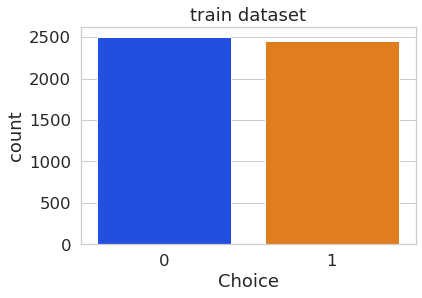

In [4]:
### dataset statistics ######
sns.countplot(x=target_col, data=df)
plt.title("train dataset")
print(df[target_col].unique())

In [5]:
###### train model ######

train = DatasetFactory.open(df).set_target(target_col)
print([train])

# create an automl job
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(training_data = train, provider=ml_engine)

# time budget is in seconds
best_model, baseline = oracle_automl.train(score_metric='roc_auc', time_budget=600)

[BinaryClassificationDataset(target: Choice) 4,950 rows, 23 columns]


Training Dataset size,"(4950, 22)"
Validation Dataset size,None
CV,5
Target variable,Choice
Optimization Metric,roc_auc
Initial number of Features,22
Selected number of Features,22
Selected Features,"[A_follower_count, A_following_count, A_listed_count, A_mentions_received, A_retweets_received, A_mentions_sent, A_retweets_sent, A_posts, A_network_feature_1, A_network_feature_2, A_network_feature_3, B_follower_count, B_following_count, B_listed_count, B_mentions_received, B_retweets_received, B_mentions_sent, B_retweets_sent, B_posts, B_network_feature_1, B_network_feature_2, B_network_feature_3]"
Selected Algorithm,ExtraTreesClassifier
End-to-end Elapsed Time (seconds),263.3
Selected Hyperparameters,"{'class_weight': None, 'criterion': 'entropy', 'max_features': 0.045454545454545456, 'min_samples_leaf': 0.00020202020202020202, 'min_samples_split': 0.00040404040404040404, 'n_estimators': 253}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,ExtraTreesClassifier_AS,4950,22,0.9493,"{'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",5.8660
3,RandomForestClassifier_AS,4950,22,0.9401,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",20.1704
4,LGBMClassifier_AS,4950,22,0.9340,"{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",4.9629
5,ExtraTreesClassifier_HT,4950,22,0.9278,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.045454545454545456, 'min_samples_leaf': 0.00020202020202020202, 'min_samples_split': 0.00040404040404040404, 'n_estimators': 253}",7.1118
6,ExtraTreesClassifier_HT,4950,22,0.9278,"{'class_weight': None, 'criterion': 'gini', 'max_features': 0.045454545454545456, 'min_samples_leaf': 0.00020202020202020202, 'min_samples_split': 0.00040404040404040404, 'n_estimators': 253}",6.4838
...,...,...,...,...,...,...
148,ExtraTreesClassifier_RandomForestClassifier_FS,4950,1,0.7487,"{'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",1.6480
149,ExtraTreesClassifier_HT,4950,22,0.6967,"{'class_weight': None, 'criterion': 'entropy', 'max_features': 0.045454545454545456, 'min_samples_leaf': 0.0014512721746132952, 'min_samples_split': 0.00040404040404040404, 'n_estimators': 5}",0.0739
150,ExtraTreesClassifier_HT,4950,22,0.6967,"{'class_weight': None, 'criterion': 'entropy', 'max_features': 0.045454545454545456, 'min_samples_leaf': 0.001456270154411275, 'min_samples_split': 0.00040404040404040404, 'n_estimators': 5}",0.0725
151,ExtraTreesClassifier_HT,4950,22,0.6345,"{'class_weight': None, 'criterion': 'entropy', 'max_features': 0.045454545454545456, 'min_samples_leaf': 0.010173941758683844, 'min_samples_split': 0.00040404040404040404, 'n_estimators': 5}",0.0701


In [10]:
###### predict test dataset ######

print(test_df.shape)

y_pred = best_model.predict(test_df)
y_true = test_df[target_col]
print(y_true.shape)

test_acc = np.mean(y_pred==y_true)
print("test accuracy = {}".format(test_acc))

import sklearn
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
test_auc = metrics.auc(fpr, tpr)
print("test auc = {}".format(test_auc))

(550, 23)
(550,)
test accuracy = 0.8836363636363637
test auc = 0.8835828396106644


In [26]:
oracle_automl.print_trials(max_rows=129, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
RandomForestClassifier_HT,29492,9,0.9261,"{'class_weight': 'balanced_subsample', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",21.8383
RandomForestClassifier_HT,29492,9,0.9259,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",16.8325
RandomForestClassifier_HT,29492,9,0.9258,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 252}",15.9579
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 101}",6.5867
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 100}",6.4813
RandomForestClassifier_HT,29492,9,0.9249,"{'class_weight': 'balanced', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",17.0242
RandomForestClassifier_HT,29492,9,0.9155,"{'class_weight': 'balanced_subsample', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 253}",54.0380
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.0012599993218499932, 'n_estimators': 100}",19.4435
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041925170481854526, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.5491
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.4114


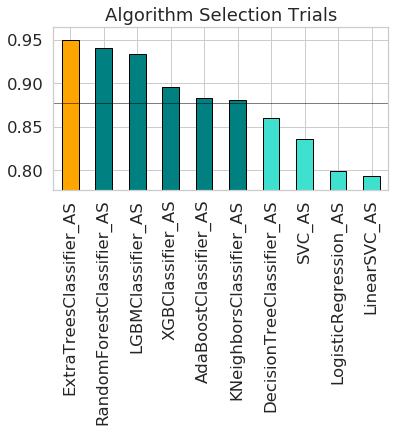

In [11]:
oracle_automl.visualize_algorithm_selection_trials()

In [14]:
###### load kaggle test dataset ######
kaggle_test_name = './d_pis/kaggle-test_{}.csv'.format(name)

kaggle_test_df = pd.read_csv(kaggle_test_name)
kaggle_test_id = np.arange(1, kaggle_test_df.shape[0]  + 1)

print(kaggle_test_df.head())
kaggle_test_df.shape

   A_follower_count  A_following_count  A_listed_count  A_mentions_received  \
0            614689                400            5729           199.618296   
1            739581              10723            1279           102.026750   
2              3638               3341              85             2.793577   
3               613               1259              31             1.326041   
4           1352348                331           15647         19129.848662   

   A_retweets_received  A_mentions_sent  A_retweets_sent    A_posts  \
0            67.812469         9.366192         0.359534   4.094488   
1            96.771319         1.537322         1.054358   3.467754   
2             1.402703         2.594089         0.598150   3.802143   
3             0.356943         6.249678         2.323064   7.488116   
4         14552.733991         2.065418         0.580955  16.281502   

   A_network_feature_1  A_network_feature_2  ...  B_following_count  \
0                  669     

(5952, 22)

In [15]:
###### predict kaggle test dataset ######

kaggle_y_pred = best_model.predict(kaggle_test_df)

assert kaggle_y_pred.shape == kaggle_test_id.shape

print(kaggle_y_pred.shape)
print(kaggle_y_pred[:100])

(5952,)
[0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0
 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0]


In [16]:
###### save kaggle prediction ######

kaggle_pred_name = './d_pis/kaggle-test_{}_predictions.csv'.format(name)

kaggle_pred_df = pd.DataFrame({id_col: kaggle_test_id, target_col: kaggle_y_pred})
print(kaggle_pred_df.head())

kaggle_pred_df.to_csv(kaggle_pred_name, index=False)

   Id  Choice
0   1       0
1   2       0
2   3       0
3   4       0
4   5       0
